### **Project** **Overview**

The aim here is to predict customer churn for ADFC bank, by leveraging the historical bank's customer attrition data which contains customer information for account holders at ADFC bank. By carefully looking at different things about ADFC Bank's customers here, we aim to identify patterns and reasons why customers might choose to leave our bank. This understanding will allow ADFC Bank to take timely actions to better serve our customers, encourage them to stay with us, and avoid losing valued members. This predictive approach will help us create specific strategies to increase customer loyalty and improve our bank's overall performance.

**Import the required dependencies.**

In [151]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_validate, train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, precision_recall_curve, auc, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.metrics import classification_report_imbalanced
!pip install opendatasets
import opendatasets as od
import joblib
import warnings
warnings.filterwarnings('ignore')

### **Data Extraction**

**Load the dataset from kaggle using kaggle api.**

In [152]:
od.download("https://www.kaggle.com/datasets/marusagar/bank-customer-attrition-insights")

Skipping, found downloaded files in "./bank-customer-attrition-insights" (use force=True to force download)


**Load the dataset and transform it to make more analysis friendly.**

In [153]:
file=r"/content/bank-customer-attrition-insights/Bank-Customer-Attrition-Insights-Data.csv"
file1=pd.read_csv(file)
file1.columns=file1.columns.str.lower()
file1.columns=file1.columns.str.replace(' ', '_')
file1.head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,complain,satisfaction_score,card_type,point_earned
0,1,15598695,Fields,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15649354,Johnston,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15737556,Vasilyev,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15671610,Hooper,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15625092,Colombo,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [154]:
file1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rownumber           10000 non-null  int64  
 1   customerid          10000 non-null  int64  
 2   surname             10000 non-null  object 
 3   creditscore         10000 non-null  int64  
 4   geography           10000 non-null  object 
 5   gender              10000 non-null  object 
 6   age                 10000 non-null  int64  
 7   tenure              10000 non-null  int64  
 8   balance             10000 non-null  float64
 9   numofproducts       10000 non-null  int64  
 10  hascrcard           10000 non-null  int64  
 11  isactivemember      10000 non-null  int64  
 12  estimatedsalary     10000 non-null  float64
 13  exited              10000 non-null  int64  
 14  complain            10000 non-null  int64  
 15  satisfaction_score  10000 non-null  int64  
 16  card_

### **Data Cleaning and Preprocessing**

In [155]:
file1.duplicated().sum()

np.int64(0)

In [156]:
file1.describe(include='O')

,surname,geography,gender,card_type
count,10000,10000,10000,10000
unique,2932,3,2,4
top,Smith,France,Male,DIAMOND
freq,32,5014,5457,2507


In [157]:
file1.describe()

,rownumber,customerid,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,complain,satisfaction_score,point_earned
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203800,0.204400,3.013800,606.515100
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402842,0.403283,1.405919,225.924839
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,1.000000,119.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,2.000000,410.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,3.000000,605.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,0.000000,4.000000,801.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,5.000000,1000.000000


**Logically, features like 'rownumber', 'customerid', 'surname' has no effect on the target feature ('exited'). So, its better to drop those to keeep our model safe.**

In [158]:
data=file1.drop(columns=['rownumber','customerid','surname'],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   creditscore         10000 non-null  int64  
 1   geography           10000 non-null  object 
 2   gender              10000 non-null  object 
 3   age                 10000 non-null  int64  
 4   tenure              10000 non-null  int64  
 5   balance             10000 non-null  float64
 6   numofproducts       10000 non-null  int64  
 7   hascrcard           10000 non-null  int64  
 8   isactivemember      10000 non-null  int64  
 9   estimatedsalary     10000 non-null  float64
 10  exited              10000 non-null  int64  
 11  complain            10000 non-null  int64  
 12  satisfaction_score  10000 non-null  int64  
 13  card_type           10000 non-null  object 
 14  point_earned        10000 non-null  int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 1.1+

In [159]:
for i in data.columns:
  print(i)
  print(data[i].value_counts())

creditscore
creditscore
850    233
678     63
655     54
705     53
667     53
      ... 
358      1
412      1
382      1
373      1
419      1
Name: count, Length: 460, dtype: int64
geography
geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64
gender
gender
Male      5457
Female    4543
Name: count, dtype: int64
age
age
37    478
38    477
35    474
36    456
34    447
     ... 
84      2
82      1
88      1
85      1
83      1
Name: count, Length: 70, dtype: int64
tenure
tenure
2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: count, dtype: int64
balance
balance
0.00         3617
130170.82       2
105473.74       2
159397.75       1
144238.70       1
             ... 
108698.96       1
238387.56       1
111833.47       1
126619.27       1
138734.94       1
Name: count, Length: 6382, dtype: int64
numofproducts
numofproducts
1    5084
2    4590
3     266
4      60
Name: count, 

**Lets, vizualize the data distribution based on target variable to have better understanding of the dataset.**

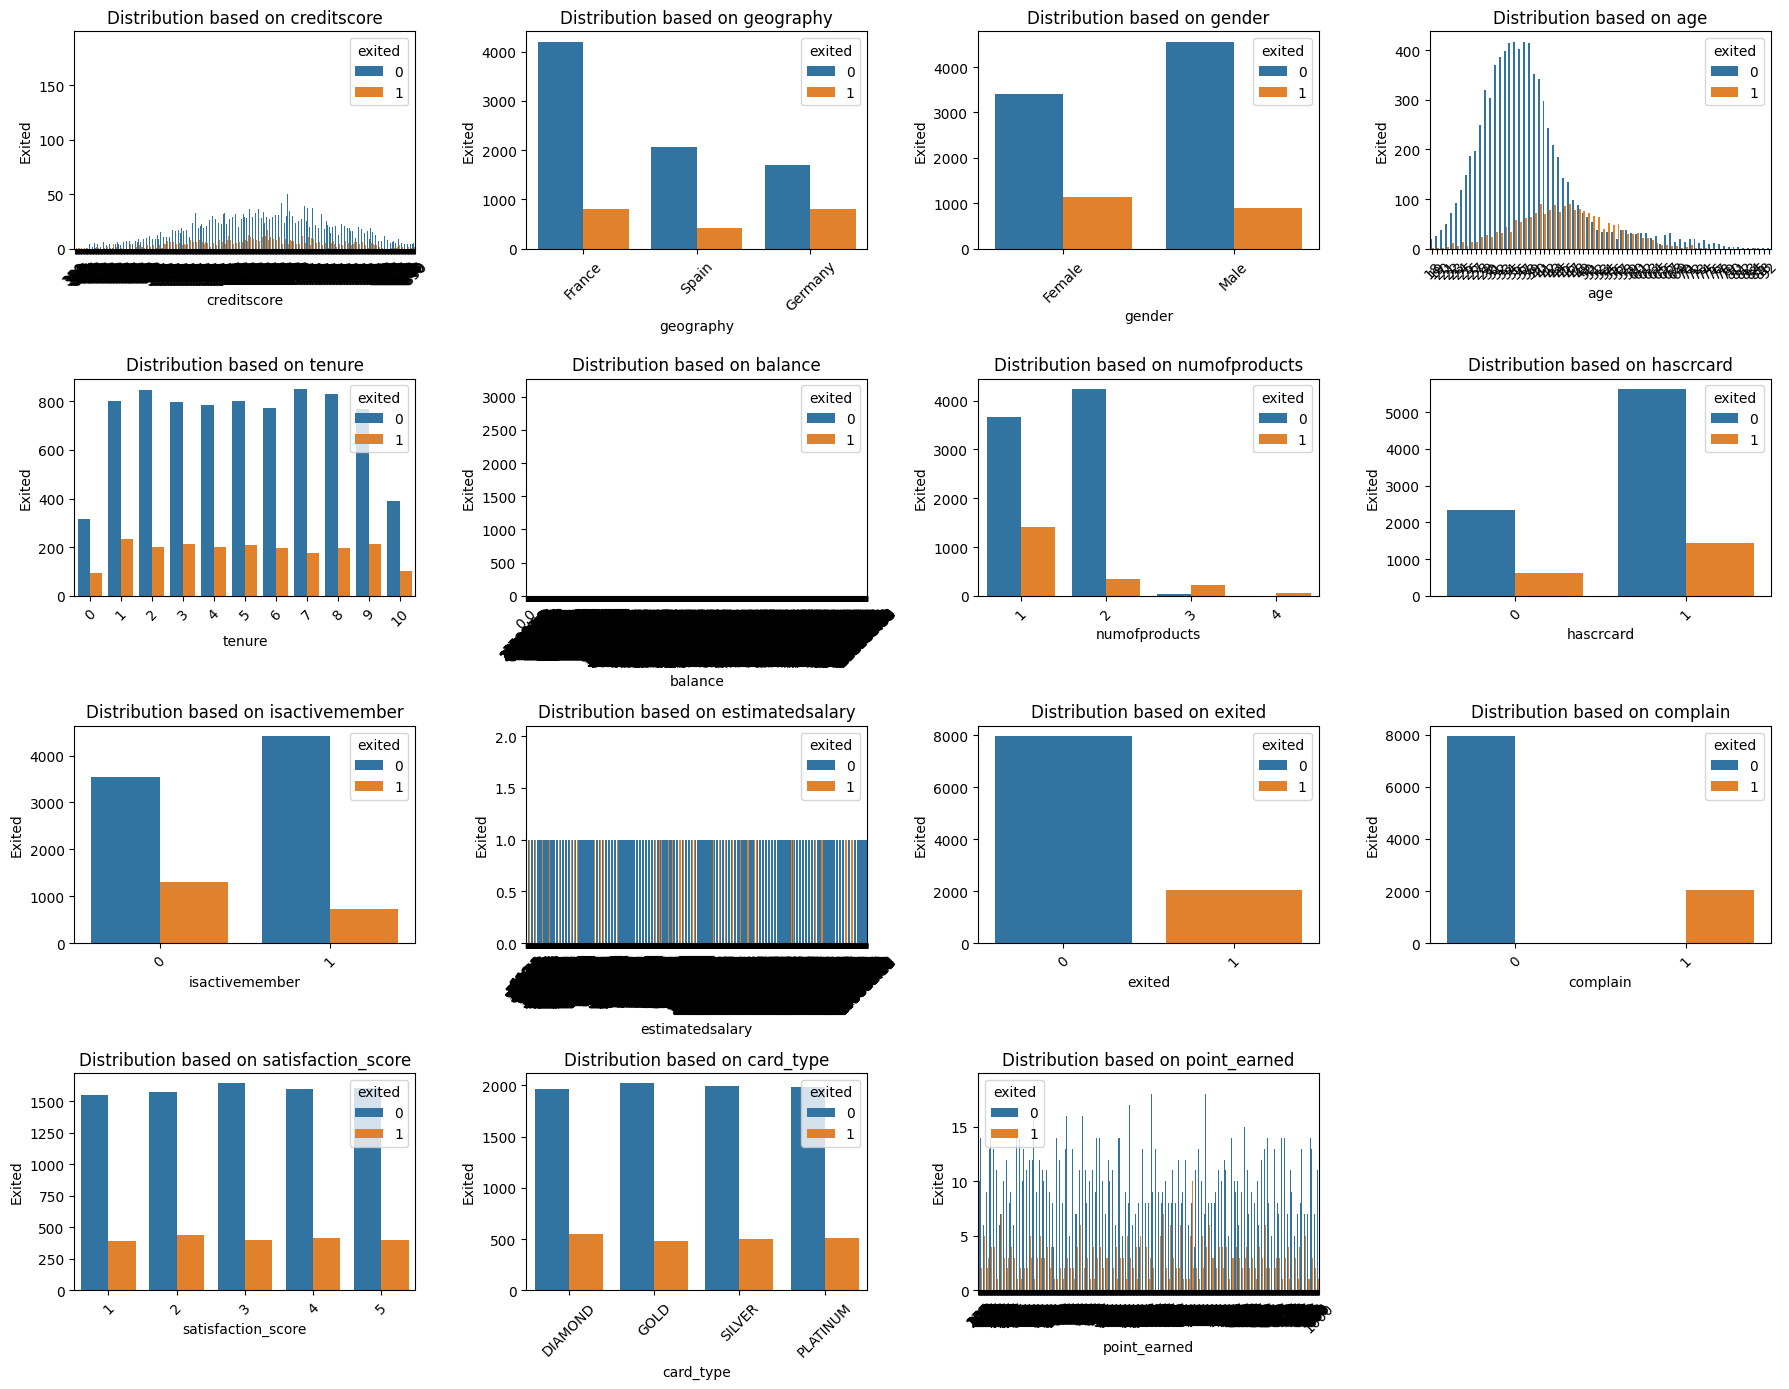

In [160]:
plt.figure(figsize=(18, 14))
for i, columns in enumerate(data.columns):
  num_o_col=len(data.columns)
  plt.subplot(4, 4, i+1)
  sns.countplot(data=data, x=columns, hue='exited')
  plt.xlabel(columns)
  plt.ylabel('Exited')
  plt.title(f'Distribution based on {columns}')
  plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**We can observe from the above graphs that the 'complain' feature is almost an exact copy of target feature. So, to avoid any information leakage its better that we drop the 'complain' feature.**

In [161]:
data1=data.drop(columns=['complain'])
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   creditscore         10000 non-null  int64  
 1   geography           10000 non-null  object 
 2   gender              10000 non-null  object 
 3   age                 10000 non-null  int64  
 4   tenure              10000 non-null  int64  
 5   balance             10000 non-null  float64
 6   numofproducts       10000 non-null  int64  
 7   hascrcard           10000 non-null  int64  
 8   isactivemember      10000 non-null  int64  
 9   estimatedsalary     10000 non-null  float64
 10  exited              10000 non-null  int64  
 11  satisfaction_score  10000 non-null  int64  
 12  card_type           10000 non-null  object 
 13  point_earned        10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


**Lets, split the data into training and testing set so that we can confirm its ability.**

In [162]:
X=data1.drop(columns=['exited'])
Y=data1['exited']
X_train, X_test, Y_train, Y_test =train_test_split(X, Y, test_size=0.3, random_state=42)

In [163]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 9069 to 7270
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   creditscore         7000 non-null   int64  
 1   geography           7000 non-null   object 
 2   gender              7000 non-null   object 
 3   age                 7000 non-null   int64  
 4   tenure              7000 non-null   int64  
 5   balance             7000 non-null   float64
 6   numofproducts       7000 non-null   int64  
 7   hascrcard           7000 non-null   int64  
 8   isactivemember      7000 non-null   int64  
 9   estimatedsalary     7000 non-null   float64
 10  satisfaction_score  7000 non-null   int64  
 11  card_type           7000 non-null   object 
 12  point_earned        7000 non-null   int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 765.6+ KB


In [164]:
Y_train.head()

,exited
9069,1
2603,0
7738,0
1579,0
5058,0


### **Feature Engineering**

**ML algorithms perfom mathematical calculations which cannot be performed in categorical features. Therefore we will use encoding methods to transform those categorical fetures into numerical ones.**

In [165]:
ohe=OneHotEncoder(drop='first', sparse_output=False)
enc=pd.DataFrame(ohe.fit_transform(X_train[['geography', 'card_type']])).reset_index(drop=True)
enc.columns=ohe.get_feature_names_out(['geography','card_type'])
enc.head()

,geography_Germany,geography_Spain,card_type_GOLD,card_type_PLATINUM,card_type_SILVER
0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0


In [166]:
odnl=OrdinalEncoder()
gndr=pd.DataFrame(odnl.fit_transform(X_train[['gender']])).rename(columns={0:'gender'}).reset_index(drop=True)
gndr.head()

,gender
0,0.0
1,0.0
2,1.0
3,1.0
4,1.0


**Merge the encoded datasets with the final one and remove the existing features.**

In [167]:
df=pd.concat([X_train.drop(columns=['gender','geography', 'card_type']).reset_index(drop=True),gndr.reset_index(drop=True), enc.reset_index(drop=True)],axis=1)
df.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,satisfaction_score,point_earned,gender,geography_Germany,geography_Spain,card_type_GOLD,card_type_PLATINUM,card_type_SILVER
0,619,32,4,175406.13,2,1,1,172792.43,1,707,0.0,0.0,1.0,0.0,0.0,0.0
1,643,34,7,160426.07,1,0,1,188533.11,3,806,0.0,1.0,0.0,1.0,0.0,0.0
2,561,33,6,0.00,2,0,0,173680.39,3,220,1.0,0.0,0.0,0.0,0.0,0.0
3,618,41,8,37702.79,1,1,1,195775.48,5,615,1.0,1.0,0.0,1.0,0.0,0.0
4,714,37,9,148466.93,2,0,1,151280.96,3,936,1.0,0.0,0.0,0.0,0.0,1.0


In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   creditscore         7000 non-null   int64  
 1   age                 7000 non-null   int64  
 2   tenure              7000 non-null   int64  
 3   balance             7000 non-null   float64
 4   numofproducts       7000 non-null   int64  
 5   hascrcard           7000 non-null   int64  
 6   isactivemember      7000 non-null   int64  
 7   estimatedsalary     7000 non-null   float64
 8   satisfaction_score  7000 non-null   int64  
 9   point_earned        7000 non-null   int64  
 10  gender              7000 non-null   float64
 11  geography_Germany   7000 non-null   float64
 12  geography_Spain     7000 non-null   float64
 13  card_type_GOLD      7000 non-null   float64
 14  card_type_PLATINUM  7000 non-null   float64
 15  card_type_SILVER    7000 non-null   float64
dtypes: flo

**Visualiza different features of the dataset to understand distribution of the continious variables from our dataset.**

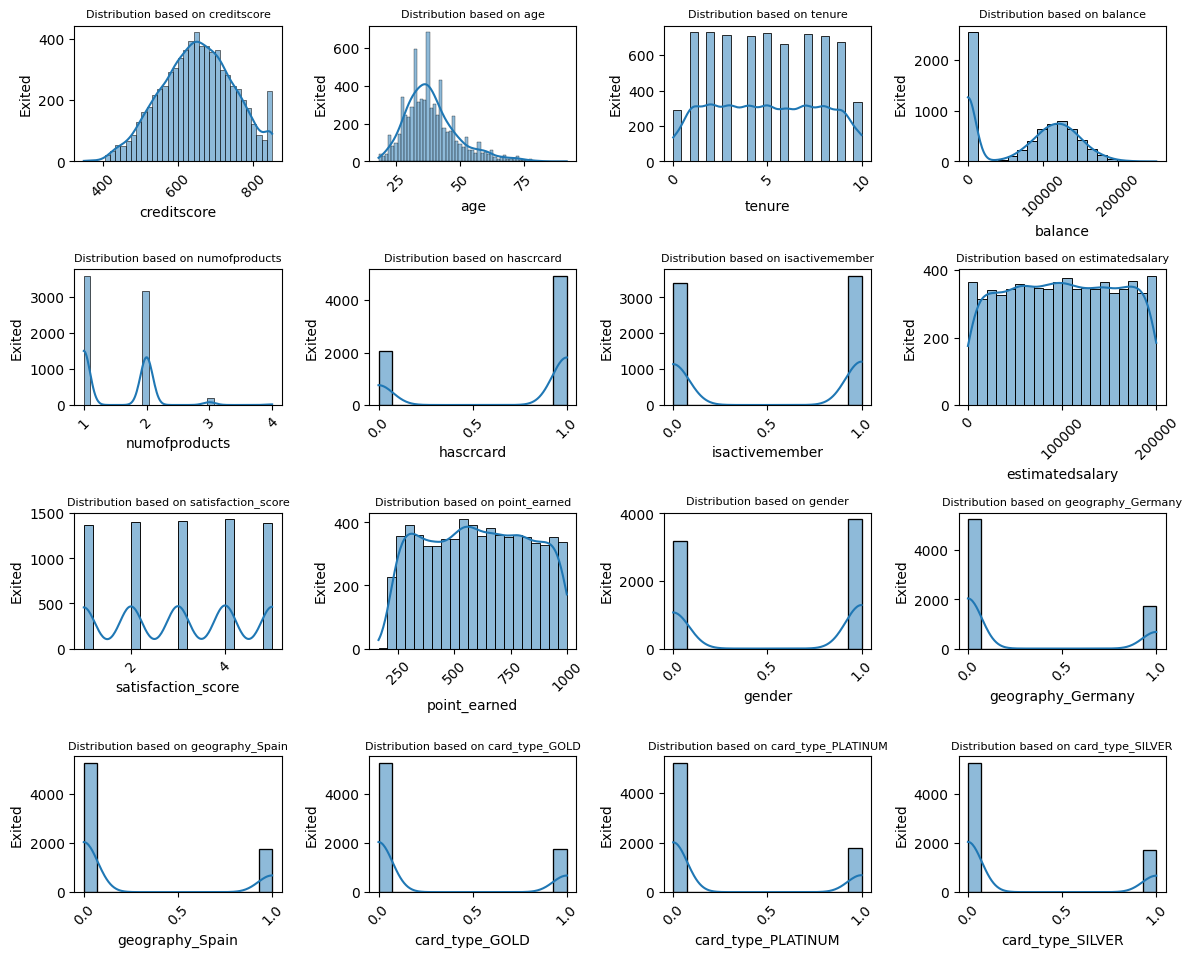

In [169]:
plt.figure(figsize=(12, 14))
for k, colu in enumerate(df.columns):
  plt.subplot(6, 4, k+1)
  sns.histplot(data=df, x=colu, kde=True)
  plt.xlabel(colu)
  plt.ylabel('Exited')
  plt.title(f'Distribution based on {colu}', fontsize=8)
  plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Correct the skewed features based on their distribution pattern.**

In [170]:
df['age_skew'] = np.log1p(df['age'])
df['creditscore_skew'] = df['creditscore']**2
df.drop(columns=['age', 'creditscore'], inplace=True)

**Lets check if the skewness problem is solved.**

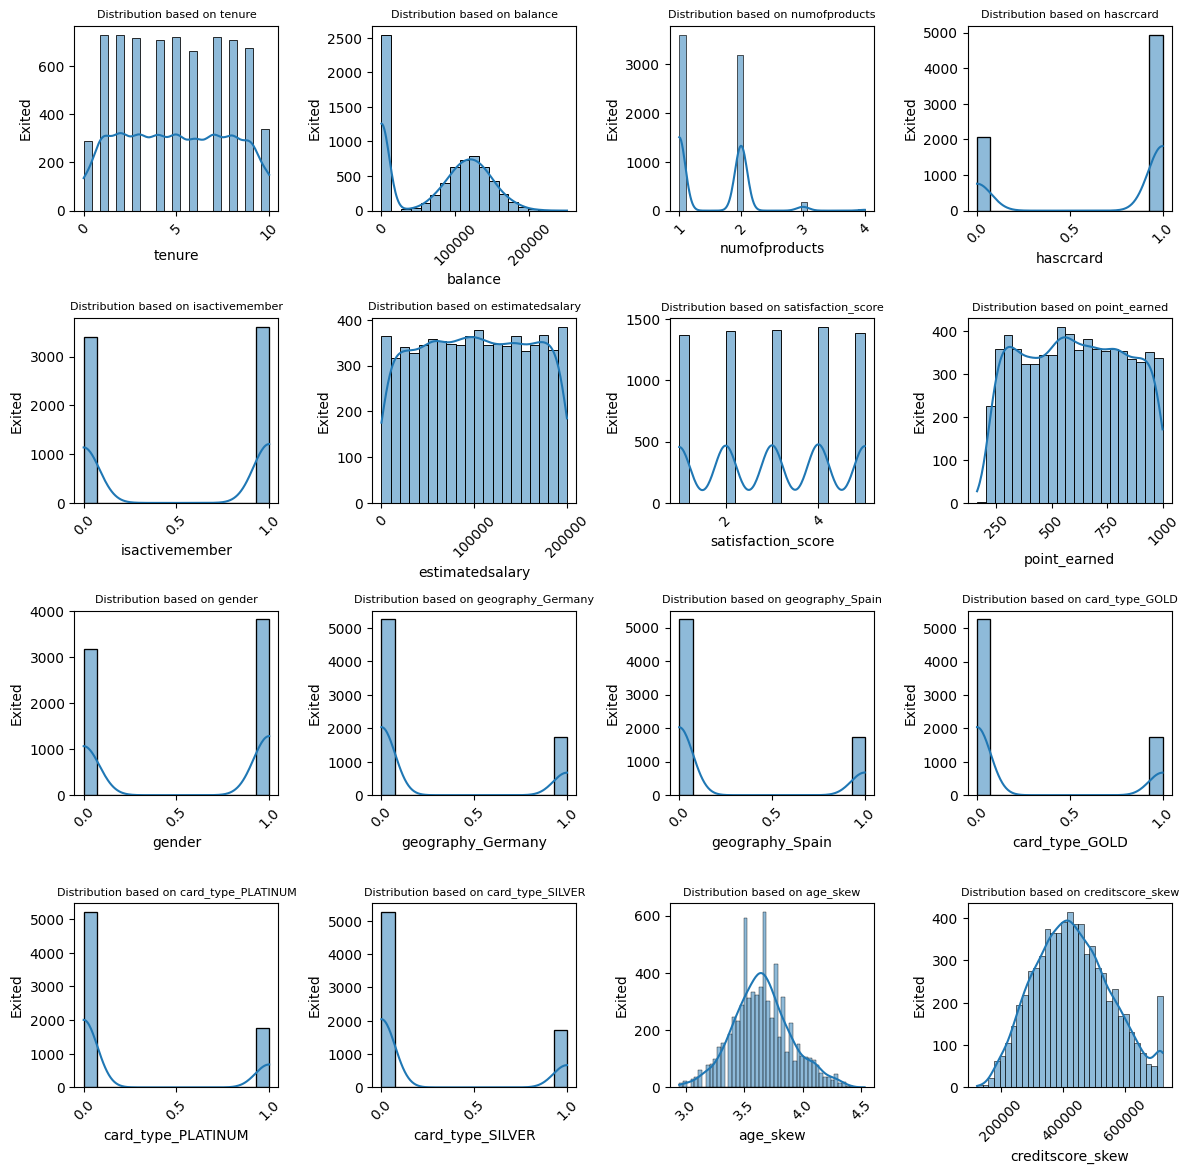

In [171]:
plt.figure(figsize=(12, 14))
for k, colu in enumerate(df.columns):
  plt.subplot(5, 4, k+1)
  sns.histplot(data=df, x=colu, kde=True)
  plt.xlabel(colu)
  plt.ylabel('Exited')
  plt.title(f'Distribution based on {colu}', fontsize=8)
  plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Feature Scaling**

In [172]:
x=df.copy()
y=Y_train.copy()
ss=StandardScaler()
x_tr_scaled=ss.fit_transform(x)

In [173]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tenure              7000 non-null   int64  
 1   balance             7000 non-null   float64
 2   numofproducts       7000 non-null   int64  
 3   hascrcard           7000 non-null   int64  
 4   isactivemember      7000 non-null   int64  
 5   estimatedsalary     7000 non-null   float64
 6   satisfaction_score  7000 non-null   int64  
 7   point_earned        7000 non-null   int64  
 8   gender              7000 non-null   float64
 9   geography_Germany   7000 non-null   float64
 10  geography_Spain     7000 non-null   float64
 11  card_type_GOLD      7000 non-null   float64
 12  card_type_PLATINUM  7000 non-null   float64
 13  card_type_SILVER    7000 non-null   float64
 14  age_skew            7000 non-null   float64
 15  creditscore_skew    7000 non-null   int64  
dtypes: flo

**Now, lets check how much influence every feature have on target variable and remove the least valuable one.**

In [174]:
smote=SMOTE(random_state=42)
x_tr_scaled_smote, y_tr_smote=smote.fit_resample(x_tr_scaled, y)

### **Model Training, Pediction and Evaluation**

**We will check multiple ML algorithms and choose the best one based on its accuracy.**

In [175]:
models={"Logistic_regression": LogisticRegression(random_state=42),
        "Support_vector": SVC(kernel='rbf', probability=True, random_state=42),
        "Adaboost": AdaBoostClassifier(random_state=42),
        "Xgboost": XGBClassifier(random_state=42)}

In [176]:
scoring = {
    'Accuracy': 'accuracy',
    'F1': 'f1_macro',
    'ROC-AUC': 'roc_auc_ovr'
    }

In [177]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results = {}

for model_name, model in models.items():
    cv_results = cross_validate(model,
    x_tr_scaled_smote, y_tr_smote,
    cv=cv,
    scoring=scoring
)
    results[model_name] = {
        'Accuracy': cv_results['test_Accuracy'].mean(),
        'F1': cv_results['test_F1'].mean(),
        'ROC-AUC': cv_results['test_ROC-AUC'].mean()
    }

cv_scores_df = pd.DataFrame(results)

In [178]:
cv_scores_df

,Logistic_regression,Support_vector,Adaboost,Xgboost
Accuracy,0.719888,0.843761,0.820231,0.903805
F1,0.719805,0.843717,0.820156,0.903744
ROC-AUC,0.789272,0.915097,0.900239,0.962240


**So, from the above result it can be observed that Xgboost has the highest 'Accuracy'. So, lets take Xgboost and perform hyperparameter tuning to check if we can further improve the Accuracy.**

In [179]:
xgb=XGBClassifier()
xgb.fit(x_tr_scaled_smote, y_tr_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### **Hyperparameter Tuning**

In [180]:
param={
    'learning_rate': [0.01, 0.03, 0.05, 0.1],  # Added 0.05 for finer control
    'max_depth': [2, 3, 4],  # Extended upper bound
    'min_child_weight': [1, 3, 6, 8],  # Lowered min value to 1
    'gamma': [0, 0.2, 0.4, 0.8],  # Added 0 to check baseline
    'subsample': [0.6, 0.8, 1.0],  # CRITICAL missing parameter
    'colsample_bytree': [0.5, 0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1, 2],  # L1 regularization
    'reg_lambda': [0, 1, 2, 4],  # L2 regularization
    'n_estimators': [600, 700, 800, 900, 1000],  # Essential for performance
    'scale_pos_weight': [1, 3, 5, 7]  # If class imbalance exists
}

In [181]:
best_model=RandomizedSearchCV(estimator=xgb, param_distributions=param, n_iter=10,
                              cv=cv, scoring=scoring, refit='Accuracy', random_state=42, verbose=3)
best_model.fit(x_tr_scaled_smote, y_tr_smote)
results_df = pd.DataFrame(best_model.cv_results_)
print(results_df[['params', 'mean_test_Accuracy', 'std_test_Accuracy', 'rank_test_Accuracy', 'mean_test_F1', 'mean_test_ROC-AUC']])

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.05, max_depth=3, min_child_weight=8, n_estimators=600, reg_alpha=0, reg_lambda=4, scale_pos_weight=1, subsample=1.0; Accuracy: (test=0.902) F1: (test=0.902) ROC-AUC: (test=0.961) total time=   0.6s
[CV 2/10] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.05, max_depth=3, min_child_weight=8, n_estimators=600, reg_alpha=0, reg_lambda=4, scale_pos_weight=1, subsample=1.0; Accuracy: (test=0.896) F1: (test=0.896) ROC-AUC: (test=0.954) total time=   0.6s
[CV 3/10] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.05, max_depth=3, min_child_weight=8, n_estimators=600, reg_alpha=0, reg_lambda=4, scale_pos_weight=1, subsample=1.0; Accuracy: (test=0.909) F1: (test=0.909) ROC-AUC: (test=0.964) total time=   0.6s
[CV 4/10] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.05, max_depth=3, min_child_weight=8, n_estimators=600, reg_alpha=0, reg_lambda=4, scale_pos

In [182]:
final=best_model.best_estimator_

In [183]:
best_model.best_params_

{'subsample': 0.6,
 'scale_pos_weight': 1,
 'reg_lambda': 4,
 'reg_alpha': 0.1,
 'n_estimators': 900,
 'min_child_weight': 6,
 'max_depth': 3,
 'learning_rate': 0.1,
 'gamma': 0.8,
 'colsample_bytree': 1.0}

In [184]:
final_model=final.fit(x_tr_scaled_smote, y_tr_smote)

**Lets see, how our model has learned from the training dataset.**

In [185]:
hy_tr_prediction=final_model.predict(x_tr_scaled_smote)

In [186]:
results = {
    'Accuracy': accuracy_score(y_tr_smote, hy_tr_prediction),
    'F1': f1_score(y_tr_smote, hy_tr_prediction),
    'ROC-AUC': roc_auc_score(y_tr_smote, final_model.predict_proba(x_tr_scaled_smote)[:, 1])
}

hy_cv_scores_df = pd.DataFrame(results, index=[0])
print('Training dataset report')
print(classification_report(y_tr_smote, hy_tr_prediction))
print(hy_cv_scores_df.to_markdown())

Training dataset report
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      5546
           1       0.97      0.92      0.94      5546

    accuracy                           0.94     11092
   macro avg       0.95      0.94      0.94     11092
weighted avg       0.95      0.94      0.94     11092

|    |   Accuracy |       F1 |   ROC-AUC |
|---:|-----------:|---------:|----------:|
|  0 |   0.944014 | 0.942473 |  0.986294 |


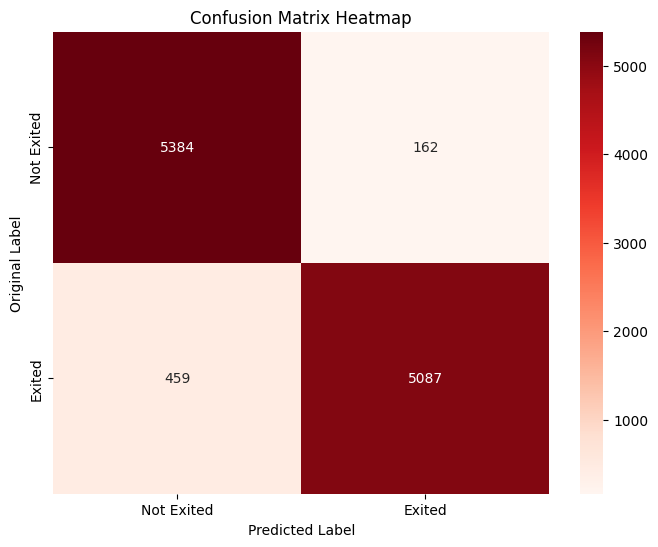

In [187]:
plt.figure(figsize=(8, 6))
class_names = ['Not Exited', 'Exited']
sns.heatmap(confusion_matrix(y_tr_smote, hy_tr_prediction), annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('Original Label')
plt.show()

### **Data Pipeline**

**Lets, build a data pipeline for easy deployment.**

In [188]:
def log_transform(X):
    return np.log1p(X)

def square_transform(X):
    return X ** 2

df = X_train.copy()

ohe_cols = []
ordinal_cols = []
for i, columns in enumerate(df.columns):
  if df[columns].dtype=='O':
    if df[columns].nunique()>2:
      ohe_cols.append(columns)
    else:
      ordinal_cols.append(columns)

log_col = ["age"]
square_col = ["creditscore"]

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(drop='first', sparse_output=False), ohe_cols),
        ('ordinal', OrdinalEncoder(), ordinal_cols),
        ('log', FunctionTransformer(log_transform), log_col),
        ('square', FunctionTransformer(square_transform), square_col),
    ],
    remainder='passthrough'
)

pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
 subsample=0.6,
 scale_pos_weight=1,
 reg_lambda=4,
 reg_alpha=0.1,
 n_estimators=900,
 min_child_weight=6,
 max_depth=3,
 learning_rate=0.1,
 gamma=0.8,
 colsample_bytree=1.0))
])

In [189]:
pipeline.fit(df, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['geography', 'card_type']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['gender']),
                                                 ('log',
                                                  FunctionTransformer(func=<function log_transform at 0x7c2725895800>),
                                                  ['age']),
                                                 ('square',
                                                  FunctionTransformer(func=<function square_transfo...
                               feature_types=None, gamma=0.8, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=6,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=900,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

In [190]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(pipeline, df, Y_train, cv=cv, verbose=3, method='predict')

results = {
    'Accuracy': accuracy_score(Y_train, y_pred_cv),
    'F1': f1_score(Y_train, y_pred_cv),
    'ROC-AUC': roc_auc_score(Y_train, pipeline.predict_proba(df)[:, 1])
}
tr_cv_scores_df = pd.DataFrame(results, index=[0])

print('    Training dataset report   ')
print(classification_report(Y_train, y_pred_cv))
print(tr_cv_scores_df.to_markdown())

    Training dataset report   
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      5546
           1       0.67      0.54      0.60      1454

    accuracy                           0.85      7000
   macro avg       0.78      0.74      0.75      7000
weighted avg       0.84      0.85      0.84      7000

|    |   Accuracy |      F1 |   ROC-AUC |
|---:|-----------:|--------:|----------:|
|  0 |   0.850429 | 0.60175 |  0.950255 |


**Lets, predict customer churn with the help of our data pipeline using the test dataset.**

In [191]:
y_pred = pipeline.predict(X_test)

results = {
    'Accuracy': accuracy_score(Y_test, y_pred),
    'F1': f1_score(Y_test, y_pred),
    'ROC-AUC': roc_auc_score(Y_test, pipeline.predict_proba(X_test)[:, 1])
}
ts_cv_scores_df = pd.DataFrame(results, index=[0])

print('    Test dataset report   ')
print(classification_report(Y_test, y_pred))
print(ts_cv_scores_df.to_markdown())

    Test dataset report   
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      2416
           1       0.68      0.54      0.60       584

    accuracy                           0.86      3000
   macro avg       0.79      0.74      0.76      3000
weighted avg       0.85      0.86      0.85      3000

|    |   Accuracy |       F1 |   ROC-AUC |
|---:|-----------:|---------:|----------:|
|  0 |   0.861333 | 0.601533 |  0.852249 |


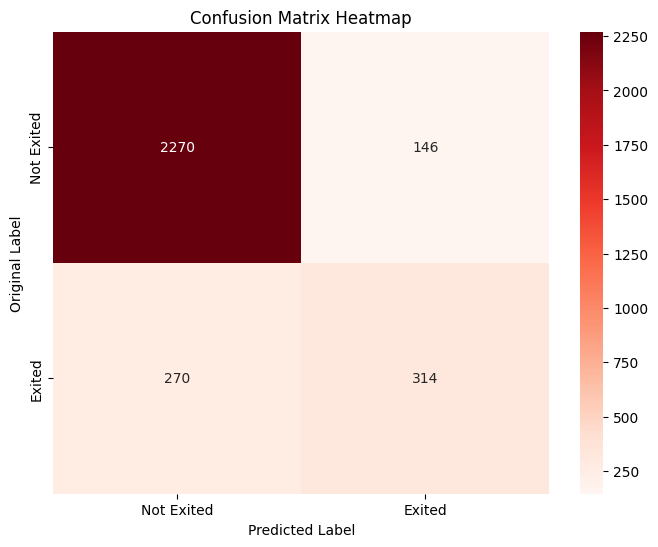

In [192]:
plt.figure(figsize=(8, 6))
class_names = ['Not Exited', 'Exited']
sns.heatmap(confusion_matrix(Y_test, y_pred), annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('Original Label')
plt.show()

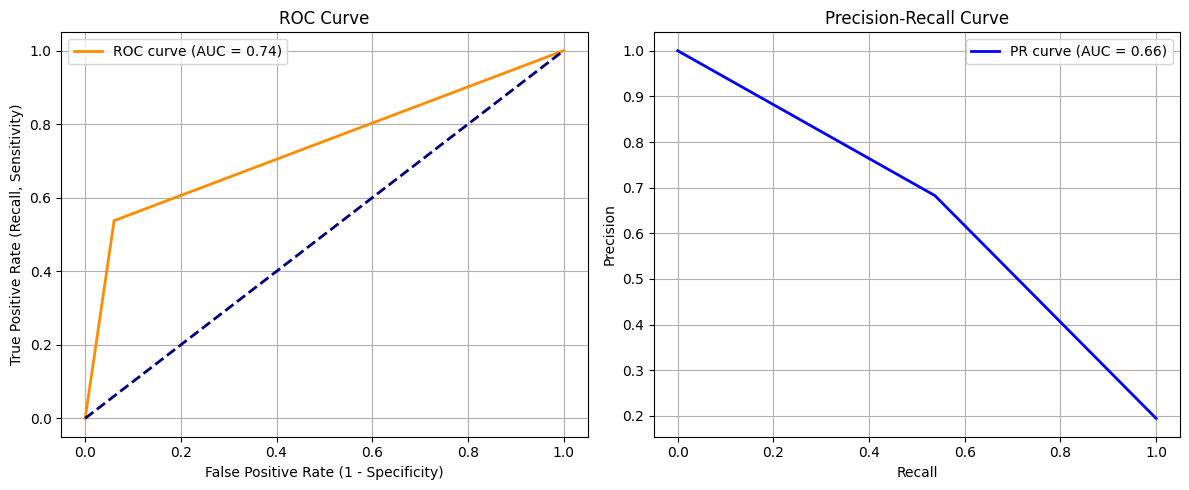

In [193]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlabel('False Positive Rate (1 - Specificity)')
ax1.set_ylabel('True Positive Rate (Recall, Sensitivity)')
ax1.set_title('ROC Curve')
ax1.grid(True)
ax1.legend(loc='best')

precision, recall, thresholds = precision_recall_curve(Y_test, y_pred)
pr_auc = auc(recall, precision)
ax2.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.grid(True)
ax2.legend(loc='best')

plt.tight_layout()
plt.show()



> ROC Curve

In this ROC curve, the orange line shows how well the model balances catching true positives and false positives as the threshold changes. The AUC score of 0.74 means the model does a decent job telling the two classes apart, but it’s not perfect. A higher AUC and a curve touching the top-left corner would mean even better performance.

\


> Precision-Recall Curve

This Precision-Recall curve shows the balance between how often the model is right when it predicts a positive case and how many of the actual positives it catches as the threshold changes. The AUC of 0.66 means the model’s performance is okay but not great. A stronger model would have a curve that sticks closer to the top-right corner with a higher AUC. This kind of plot is especially handy when working with imbalanced data, where we really care about picking up the rare class.


In [194]:
joblib.dump(pipeline, 'model_pipeline.joblib')

['model_pipeline.joblib']

### **Summary**

The model demonstrates strong performance for Class 0 but underperforms for Class 1.

\

> **Class 0**



**Precision (0.89)**: 90% of the time the model perfectly predicts class 0 but 11% of these predictions are incorrect.

**Recall (0.94):** The model successfully identifies 94% of all actual class 0 instances in the dataset but again missing 6%.

**F1-score (0.92):** This indicates excellent balance between precision and recall for class 0.

\

> **Class 1**

**Precision (0.68):** 68% of the time the model predicts class 1 but 32% are false positives.

**Recall (0.54):** The model predicts only 54% of all true Class 1 instances, with other 46% as false negatives.

**F1-score (0.60):** The low score reflects poor harmony between precision and recall.

\


* Overall the Accuracy of 0.86 seems high, it looks like its inflated by the model’s strength in classifying Class 0.

* Macro F1 of 0.76 for both classes, confirms uneven performance.

* Weighted F1 (0.85): Weighted by class size, so its closer to Class 0’s performance.

\
In Short, the model seems to be reliable for Class 0 but misses nearly half of Class 1 cases. The results suggest its better at identifying what Class 1 is not (i.e., Class 0) than what Class 1 is.

Although i have applied techniques like SMOTE and StratifiedKfold to deal with the imbalnce data in our dataset but
still the effects of imbalance dataset
can be observed in the test result. So, we can imply some other steps which may improve our result, like:

 \



*   Boosting Class 1 recall by lowering the prediction threshold or using 'scale_pos_weight'
*   Address class imbalance with some other strong technique other than  SMOTE or perform undersampling

